# Flight Delay Analysis and EDA

In [45]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, floor

# Magic command to display plots inline in Jupyter
%matplotlib inline

## 1. Data Ingestion

In [46]:
file_path = "flights_sample_3m.csv"
spark = SparkSession.builder.appName("FlightDelayPredictor").getOrCreate()
df = spark.read.csv(file_path, header=True, inferSchema=True)

#Schema and print data to verify that the file loaded 
print("Data loaded. Schema:")
df.printSchema()
print("Sample of 5 rows:")
df.show(5)

Data loaded. Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: dou

## 2. Initial Cleaning & Target Creation

In [47]:
#Remove cancelled and delayed flights
df_filtered = df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0))

#These are the features we will use for training the model other features like DEP_TIME and DEP_DELAY
#Will be removed as they are leaky and will mess with the training of the model
columns_to_keep = [
    "FL_DATE",
    "FL_NUMBER",
    "AIRLINE",
    "ORIGIN",
    "DEST",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "ARR_DELAY"
]

df_selected = df_filtered.select(columns_to_keep)

print(f"Count before validation: {df_selected.count()}")

Count before validation: 2913804


### Data Validation

In [48]:
df_validated = df_selected.filter(
   # 1. Time Validation
    ((col("CRS_DEP_TIME") >= 0)&(col("CRS_DEP_TIME") <= 2359)&(col("CRS_DEP_TIME") % 100 < 60))&((col("CRS_ARR_TIME") >= 0) & (col("CRS_ARR_TIME") <= 2359)&(col("CRS_ARR_TIME") % 100 < 60))&

    # 2. Physical Validation
    (col("DISTANCE") > 10) &                                        # Min distance > 10 miles
    (col("DISTANCE") < 10000) &                                     # Max distance < 10,000 miles (longest flight is ~9.5k)
    (col("CRS_ELAPSED_TIME") > 10) &                                # Min scheduled time > 10 minutes
    ( (col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) < 700 ) &  # checking for impossible speeds max 700mph
    ( (col("DISTANCE") / (col("CRS_ELAPSED_TIME") / 60)) > 50 ) &   # min 50mph

    # 3. Logical Validation
    (col("ORIGIN") != col("DEST")) &                                 # Origin and Destination can't be the same
    
    # 4. Empty string check
    (col("AIRLINE") != "")&(col("ORIGIN") != "")&(col("DEST") != "")
)


# If delay > 15 mins, mark delayed
# DepHour holds the hour of the day
df_with_target = df_validated.withColumn("Is_Delayed", when(col("ARR_DELAY") > 15, 1).otherwise(0)).withColumn("DepHour", floor(col("CRS_DEP_TIME") / 100).cast("integer"))

final_columns = [
    "FL_DATE", "AIRLINE", "ORIGIN", "DEST", "DepHour", 
    "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "Is_Delayed"
]

#drop null values
df_cleaned = df_with_target.select(final_columns).na.drop(subset=final_columns)

print(f"Count after validation: {df_cleaned.count()}")


print("Cleaning complete. New schema:")
df_cleaned.printSchema()
df_cleaned.show(5)

Count after validation: 2913776
Cleaning complete. New schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- Is_Delayed: integer (nullable = false)

+----------+--------------------+------+----+-------+------------+----------------+--------+----------+
|   FL_DATE|             AIRLINE|ORIGIN|DEST|DepHour|CRS_ARR_TIME|CRS_ELAPSED_TIME|DISTANCE|Is_Delayed|
+----------+--------------------+------+----+-------+------------+----------------+--------+----------+
|2019-01-09|United Air Lines ...|   FLL| EWR|     11|        1501|           186.0|  1065.0|         0|
|2022-11-19|Delta Air Lines Inc.|   MSP| SEA|     21|        2315|           235.0|  1399.0|         0|
|2022-07-22|United Air Lines ...|   DEN| MSP

## 3. Exploratory Data Analysis (EDA)

In [49]:
# Create a temporary view to run SQL queries
df_cleaned.createOrReplaceTempView("flights")

### Q: "Which airports are most prone to delays?"

In [50]:
print("Top 5 Origin Airports with Highest Delay Rate:")
spark.sql("""
    SELECT 
        ORIGIN, 
        COUNT(*) AS Total_Flights,
        AVG(Is_Delayed) AS Delay_Rate
    FROM flights
    GROUP BY ORIGIN
    HAVING Total_Flights > 1000 -- Only look at airports with decent traffic
    ORDER BY Delay_Rate DESC
""").show(5)

Top 5 Origin Airports with Highest Delay Rate:


+------+-------------+-------------------+
|ORIGIN|Total_Flights|         Delay_Rate|
+------+-------------+-------------------+
|   ASE|         2576|0.28959627329192544|
|   EWR|        50808|0.23553377420878602|
|   PGD|         2720|0.23272058823529412|
|   EYW|         3350|0.23044776119402985|
|   MCO|        62027|0.22877134151256712|
+------+-------------+-------------------+
only showing top 5 rows


### Q: "Which airlines have the worst delays?"

In [51]:
print("Delay Rate by Airline:")
spark.sql("""
    SELECT 
        AIRLINE, 
        COUNT(*) AS Total_Flights,
        AVG(Is_Delayed) AS Delay_Rate
    FROM flights
    GROUP BY AIRLINE
    ORDER BY Delay_Rate DESC
""").show()

Delay Rate by Airline:


+--------------------+-------------+-------------------+
|             AIRLINE|Total_Flights|         Delay_Rate|
+--------------------+-------------+-------------------+
|     JetBlue Airways|       109437|0.26286356533896216|
|Frontier Airlines...|        62712|0.25921673682867713|
|       Allegiant Air|        50179|  0.252695350644692|
|    Spirit Air Lines|        93196|0.21432250311172155|
|ExpressJet Airlin...|        17951|0.20817781739178876|
|American Airlines...|       371218|0.19250413503655533|
|Southwest Airline...|       555869|0.18555271116036332|
|United Air Lines ...|       248270|0.18536673782575422|
|  Mesa Airlines Inc.|        62470|0.18066271810469026|
|Alaska Airlines Inc.|        98293|0.17376618884355957|
|   PSA Airlines Inc.|       103483|0.16746712020331841|
|           Envoy Air|       117312|0.16739123022367702|
|Hawaiian Airlines...|        31698|0.15483626727238312|
|SkyWest Airlines ...|       334984|0.15347001647839897|
|    Republic Airline|       13

### Q: "How does delay rate change by hour of day?"

In [52]:
print("Delay Rate by Departure Hour:")
spark.sql("""
    SELECT 
        DepHour, 
        COUNT(*) AS Total_Flights,
        AVG(Is_Delayed) AS Delay_Rate
    FROM flights
    GROUP BY DepHour
    ORDER BY DepHour
""").show()

Delay Rate by Departure Hour:


+-------+-------------+-------------------+
|DepHour|Total_Flights|         Delay_Rate|
+-------+-------------+-------------------+
|      0|         5548| 0.1688896899783706|
|      1|         2006| 0.1814556331006979|
|      2|          707| 0.2333804809052334|
|      3|          507|0.22682445759368836|
|      4|          314|0.20382165605095542|
|      5|        62295|0.08052010594750783|
|      6|       204776|0.08996171426339024|
|      7|       198435|0.10832262453700205|
|      8|       201690|0.12163716594774159|
|      9|       173092|  0.132750213759157|
|     10|       186748| 0.1423736800394114|
|     11|       185435| 0.1484832960336506|
|     12|       178983|0.16533413787901644|
|     13|       175936|0.17818979628955983|
|     14|       172803|0.19633918392620497|
|     15|       173989| 0.2096741748041543|
|     16|       168207| 0.2233616912494724|
|     17|       183444|0.22867469091384837|
|     18|       173812|0.24237106759026994|
|     19|       153713|0.2491071

### Visualizing Delay Rate by Hour

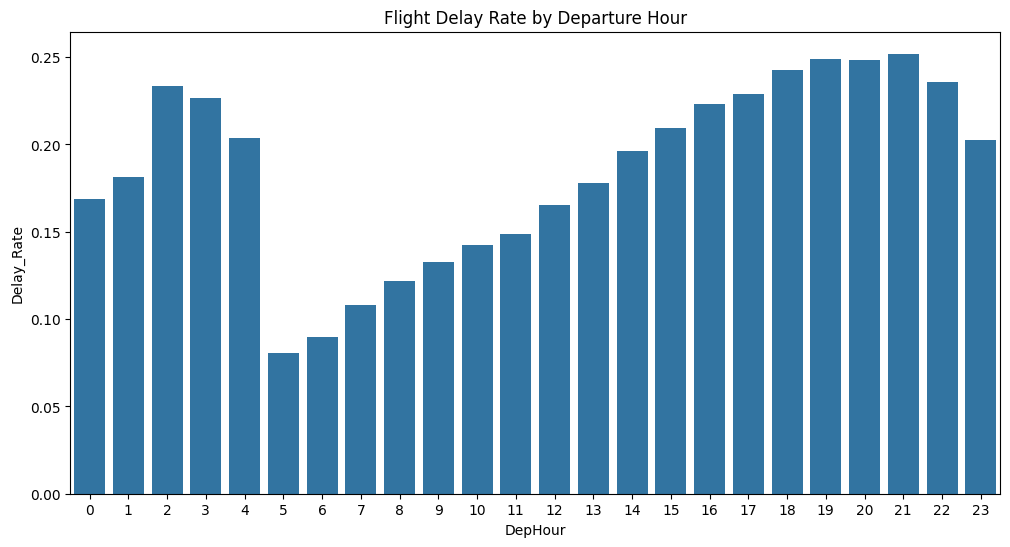

In [53]:
# Get the "delay by hour" data
hour_data_pd = spark.sql("SELECT DepHour, AVG(Is_Delayed) AS Delay_Rate FROM flights GROUP BY DepHour ORDER BY DepHour").toPandas()

# Plot it
plt.figure(figsize=(12, 6))
sns.barplot(data=hour_data_pd, x="DepHour", y="Delay_Rate")
plt.title("Flight Delay Rate by Departure Hour")
plt.show() # <-- Changed from savefig to display inline

## 4. Benchmarking

In [54]:
# --- PySpark Benchmark ---
print("Running PySpark aggregation...")
start_spark = time.time()


df.filter((col("CANCELLED") == 0) & (col("DIVERTED") == 0)) \
  .groupBy("ORIGIN") \
  .count() \
  .collect()

end_spark = time.time()
print(f"PySpark Time: {end_spark - start_spark:.4f} seconds")

Running PySpark aggregation...


PySpark Time: 0.9000 seconds


In [55]:
# --- Pandas Benchmark ---
print("Running Pandas aggregation...")
start_pandas = time.time()

try:
    pandas_df = pd.read_csv(
        file_path, 
        usecols=["ORIGIN", "CANCELLED", "DIVERTED"]
    )

    pandas_df_filtered = pandas_df[
        (pandas_df["CANCELLED"] == 0) & (pandas_df["DIVERTED"] == 0)
    ]

    pandas_df_filtered.groupby("ORIGIN").size()
    
    end_pandas = time.time()
    print(f"Pandas Time: {end_pandas - start_pandas:.4f} seconds")

except Exception as e:
    print(f"Pandas failed: {e}")

Running Pandas aggregation...
Pandas Time: 1.7888 seconds


### Q: "How does delay rate change by Day of Week?"

Delay Rate by Day of Week:


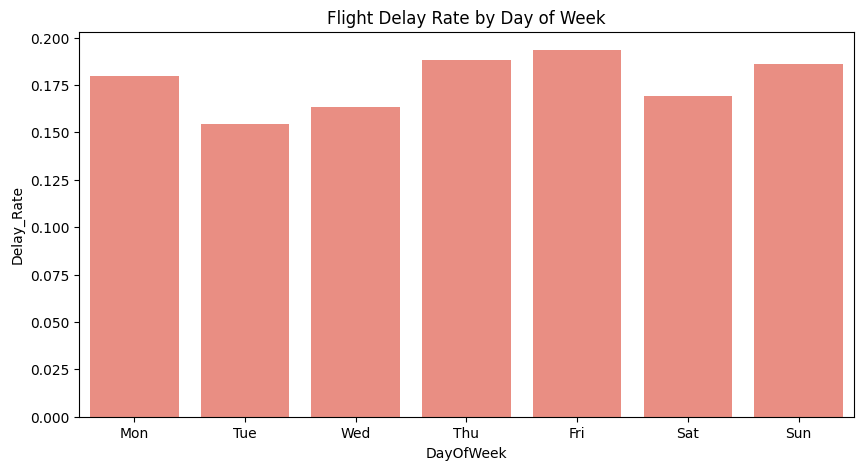

In [56]:
print("Delay Rate by Day of Week:")

# We use date_format 'E' to get the 3-letter day of the week (e.g., 'Mon').
# The CASE statement is to sort the days logically instead of alphabetically.
dow_data_sql = """
    SELECT 
        date_format(FL_DATE, 'E') AS DayOfWeek,
        AVG(Is_Delayed) AS Delay_Rate,
        CASE
            WHEN date_format(FL_DATE, 'E') = 'Mon' THEN 1
            WHEN date_format(FL_DATE, 'E') = 'Tue' THEN 2
            WHEN date_format(FL_DATE, 'E') = 'Wed' THEN 3
            WHEN date_format(FL_DATE, 'E') = 'Thu' THEN 4
            WHEN date_format(FL_DATE, 'E') = 'Fri' THEN 5
            WHEN date_format(FL_DATE, 'E') = 'Sat' THEN 6
            WHEN date_format(FL_DATE, 'E') = 'Sun' THEN 7
        END AS DayOfWeekSort
    FROM flights
    GROUP BY DayOfWeek
    ORDER BY DayOfWeekSort
"""
dow_data_pd = spark.sql(dow_data_sql).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=dow_data_pd, x="DayOfWeek", y="Delay_Rate", color="salmon")
plt.title("Flight Delay Rate by Day of Week")
plt.show()

### Q: "Does flight distance affect delays?"

Delay Rate by Flight Distance:


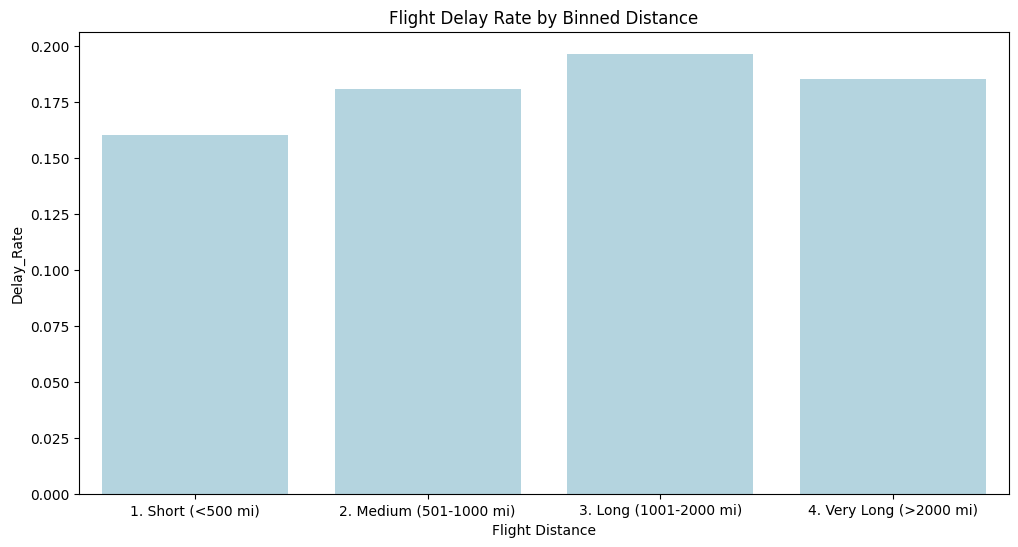

In [57]:
print("Delay Rate by Flight Distance:")

# We use a CASE WHEN statement to bin the continuous 'DISTANCE' feature
# into a few categories for easier visualization.
distance_sql = """
    SELECT 
        CASE 
            WHEN DISTANCE <= 500 THEN '1. Short (<500 mi)'
            WHEN DISTANCE <= 1000 THEN '2. Medium (501-1000 mi)'
            WHEN DISTANCE <= 2000 THEN '3. Long (1001-2000 mi)'
            ELSE '4. Very Long (>2000 mi)'
        END AS Distance_Bin,
        AVG(Is_Delayed) AS Delay_Rate
    FROM flights
    GROUP BY Distance_Bin
    ORDER BY Distance_Bin
"""
distance_data_pd = spark.sql(distance_sql).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=distance_data_pd, x="Distance_Bin", y="Delay_Rate", color="lightblue")
plt.title("Flight Delay Rate by Binned Distance")
plt.xlabel("Flight Distance")
plt.show()

### Q: "Are some airlines worse at certain times of day?"

Heatmap of Delay Rate by Airline and Departure Hour:


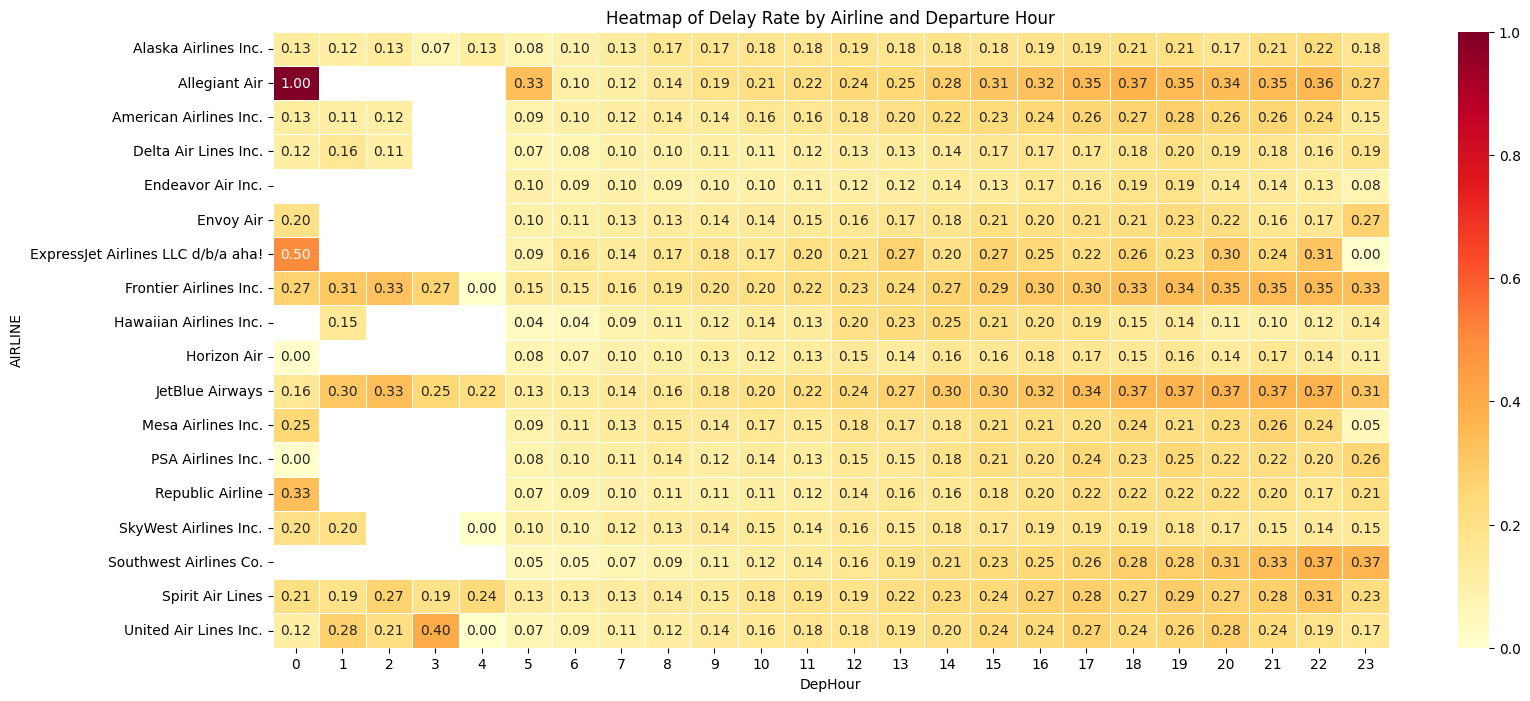

In [58]:
print("Heatmap of Delay Rate by Airline and Departure Hour:")

# First, get the average delay rate for each Airline/Hour combination
heatmap_sql = """
    SELECT 
        AIRLINE,
        DepHour,
        AVG(Is_Delayed) AS Delay_Rate
    FROM flights
    GROUP BY AIRLINE, DepHour
"""
heatmap_data_pd = spark.sql(heatmap_sql).toPandas()

# Now, pivot the data so Airlines are rows, DepHour are columns,
# and the values are the Delay_Rate
try:
    heatmap_pivot = heatmap_data_pd.pivot(index="AIRLINE", columns="DepHour", values="Delay_Rate")
    
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=.5)
    plt.title("Heatmap of Delay Rate by Airline and Departure Hour")
    plt.show()

except Exception as e:
    print(f"Could not generate heatmap: {e}")
    print("This can happen if some airlines have no flights at certain hours, creating NaNs.")